# P9120 HW3 Q3

The “spam” data” ( https://web.stanford.edu/hastie/ElemStatLearn/data) has been divided into a training set and a test set. Fit a neural network to the training set, and calculate its classification error on the test set. Compare your results to the classification tree results presented in Section 9.2.5 of [ESL] on both the classification performance and interpretability of the final model.

In [132]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import seed
seed(2022)
tf.random.set_seed(2)

In [133]:
plt.rcParams['figure.figsize'] = (14,10)

In [134]:
## Read in data
X_train = pd.read_csv("X_train.csv", header = 0, index_col = 0)
X_train = X_train.reset_index(drop=True)
y_train = pd.read_csv("y_train.csv", header = 0, index_col = 0)
y_train = y_train.reset_index(drop=True)

X_test = pd.read_csv("X_test.csv", header = 0, index_col = 0)
X_test = X_test.reset_index(drop=True)
y_test = pd.read_csv("y_test.csv", header = 0, index_col = 0)
y_test = y_test.reset_index(drop=True)

## Use Keras to build a sequential model of 3 hidden layers, 2 dropout layers

In [135]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

Taking 20% data out as our validation set

In [136]:
# validation set
X_train_, X_val = train_test_split(X_train, test_size=0.2, random_state = 42)
y_train_, y_val = train_test_split(y_train, test_size=0.2, random_state = 42)

In [137]:
# create model
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')
]

model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
]);
    
# Compile model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
              loss = keras.losses.BinaryCrossentropy(), 
              metrics=METRICS)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 256)               14848     
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_26 (Batc (None, 128)               512       
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)              

In [138]:
EPOCHS = 100
BATCH_SIZE = 40

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc', 
    verbose=2,
    patience=20,
    mode='max',
    restore_best_weights=True)

history = model.fit(
    X_train_, 
    y_train_, 
    epochs=200, 
    validation_split=0.20,
    callbacks=[early_stopping],
    batch_size=40, 
    verbose=0, 
    validation_data=(X_val, y_val)
)

In [139]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.1754


### History Checking

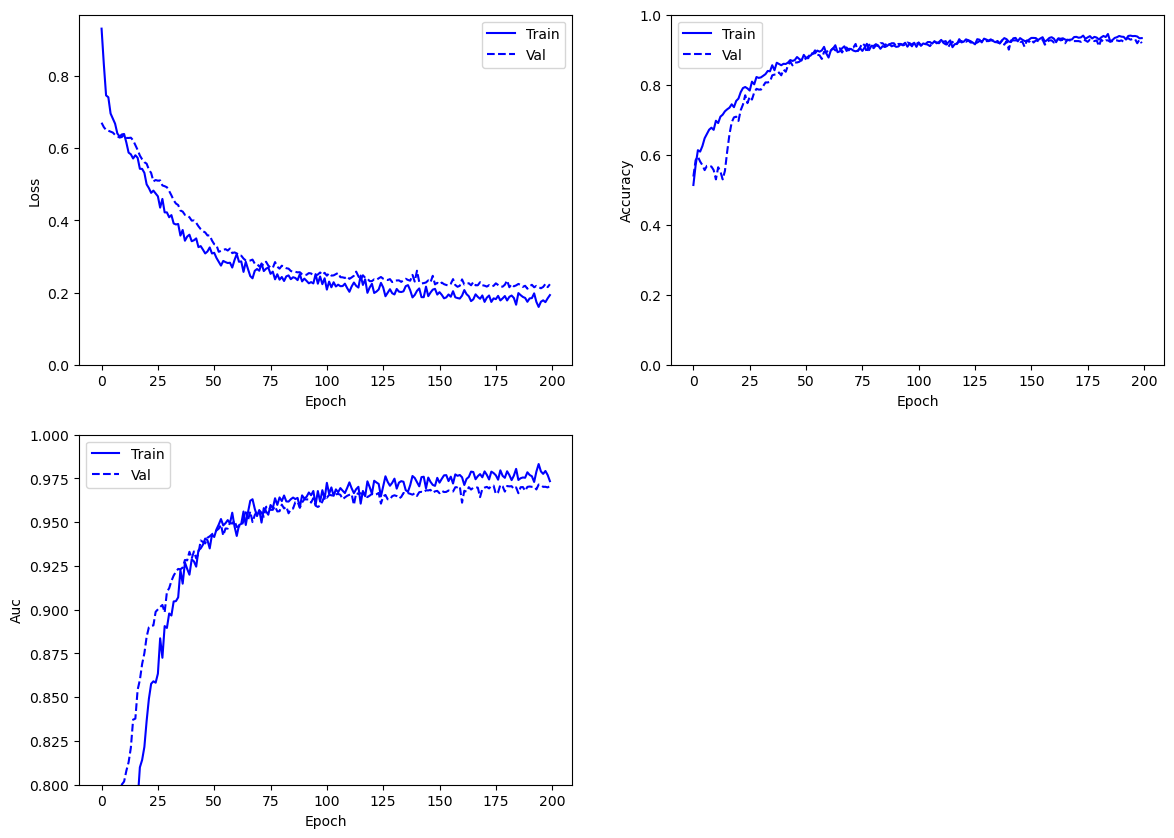

In [140]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'auc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], 
                 color='b', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='b', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
plot_metrics(history)

As the number of Epoch grows, the training and validation error decreases and the ROC AUC increases. Our training is indeed effective.

Then we can use the model to predict the test set:

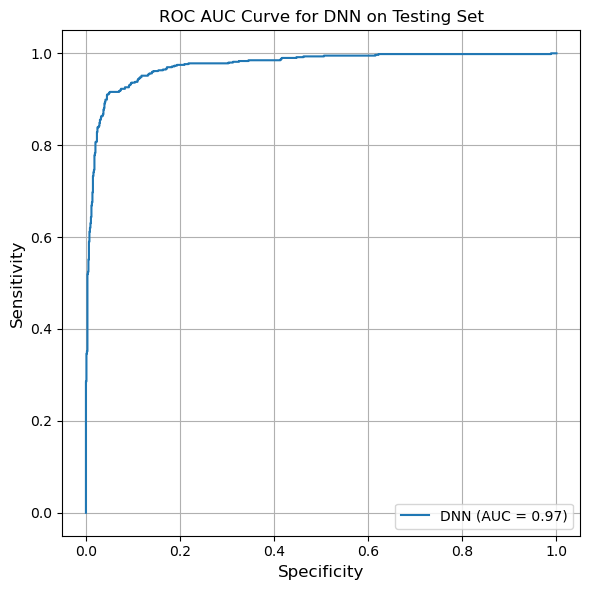

In [141]:
test_pred = model.predict(X_test, batch_size=BATCH_SIZE)
plt.rcParams['figure.figsize'] = (6,6)
RocCurveDisplay.from_predictions(y_test, test_pred, name = 'DNN')
plt.title("ROC AUC Curve for DNN on Testing Set")
plt.xlabel("Specificity", fontsize = 12)
plt.ylabel("Sensitivity", fontsize = 12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.tight_layout()
plt.show()

Calculate classification error:

In [143]:
# RSS
test_error = np.mean((np.array(y_test)-test_pred)**2)
## sqrt(RSS/(n-2))
test_error_sd = np.mean(
    np.sqrt((np.array(y_test)-test_pred)**2/(X_test.shape[0]-2)))
print("The classification error on the test set is %.3f and the standard deviation is %.3f" % (test_error, test_error_sd))

The classification error on the test set is 0.061 and the standard deviation is 0.003


* The classification error on the test set of the DNN model ($0.061 \pm 0.003$) is better than that of the classification tree's, and it also gives a better classification rule for any loss with an area of 0.97 (0.97 > 0.95). 
* However, the as shown on Fig. 9.5, the pruned tree from the classification tree result can be easily interpreted. The DNN model is black-boxed, therefore it is lack of interpretability compared to the classification tree.